In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
basedir = "D:/Raphael/Data/3. Plasmid moves cargo into Lysosomes"
df = pd.read_excel(os.path.join(basedir,"Results.xlsx"))
df = df[df["Group2"]=="LAMP1"]
df.head()

,Unnamed: 0,label,bbox-0,bbox-1,bbox-2,bbox-3,label_aSyn-GFP,bbox-0_aSyn-GFP,bbox-1_aSyn-GFP,bbox-2_aSyn-GFP,...,Channel_1,Channel_aSyn-AB,Channel_2,Channel_LAMP1/LC3,ROI_path,Replicate,Group1,Group2,path,denoised_path
0,0,3,685,797,1413,1464,3,685,797,1413,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LAMP1,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
1,1,1,504,721,1597,1402,1,504,721,1597,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LAMP1,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
2,2,5,269,703,789,1193,5,269,703,789,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LAMP1,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
3,3,6,589,716,1683,1388,6,589,716,1683,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LAMP1,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
4,4,3,628,1073,1351,1678,3,628,1073,1351,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LAMP1,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...


In [5]:
from ImageOperations import get_cropped, getImage, get_mask, get_ROI
from NearestNeighbour import NearestNeighbour
from DetectPoints import detect_points
from tqdm import tqdm
def get_R(lower,upper):
    xlen = 0.0753084
    r = np.linspace(lower/xlen,upper/xlen,100)
    return r

def calculate_NN(df,R):
    data = {
        "L":[],
        "r":[],
        "X":[],
        "Y":[],
        "Group":[],
        "Stack":[],
        "CID":[],
        "Rep":[],
        "LenX":[],
        "LenY":[]
    }
    for CID in tqdm(df["CID"].values):
        rep = df[df["CID"]==CID]["Replicate"].values[0]
        g = df[df["CID"]==CID]["Group1"].values[0]
        ROI = get_ROI(df,CID)
        GFPimage = get_cropped(df,CID,0).astype("uint8")
        ABimage = get_cropped(df,CID,1).astype("uint8")
        LC3image = get_cropped(df,CID,2).astype("uint8")
        boundary = ROI.coordinates()-[[ROI.left,ROI.top]]
        for i in range(GFPimage.shape[0]):
            GFP = detect_points(GFPimage[i,:,:],ROI,ntol=50)
            AB = detect_points(ABimage[i,:,:],ROI,ntol=50)
            LAMP1 = detect_points(LC3image[i,:,:],ROI,ntol=200)
            #GFP - LC3
            if len(GFP) != 0 and len(LAMP1) != 0:
                data["L"]=[*data["L"],*NearestNeighbour(GFP,LAMP1,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["GFP"]*len(R))]
                data["Y"]=[*data["Y"],*(["LAMP1"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(GFP)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(LAMP1)]*len(R))]
            #AB - LC3
            if len(AB) != 0 and len(LAMP1) != 0:
                data["L"]=[*data["L"],*NearestNeighbour(AB,LAMP1,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["AB"]*len(R))]
                data["Y"]=[*data["Y"],*(["LAMP1"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(AB)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(LAMP1)]*len(R))]
            #LC3 - GFP
            if len(GFP) != 0 and len(LAMP1) != 0:
                data["L"]=[*data["L"],*NearestNeighbour(LAMP1,GFP,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["LAMP1"]*len(R))]
                data["Y"]=[*data["Y"],*(["GFP"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(LAMP1)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(GFP)]*len(R))]
            #LC3 - AB
            if len(AB) != 0 and len(LAMP1) != 0:
                data["L"]=[*data["L"],*NearestNeighbour(LAMP1,AB,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["LAMP1"]*len(R))]
                data["Y"]=[*data["Y"],*(["AB"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(LAMP1)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(AB)]*len(R))]
    return pd.DataFrame(data=data)

R = get_R(0,0.5)
df2 = calculate_NN(df,R)
df2.to_csv(os.path.join(basedir,"LAMP1_NN_coloc.csv"),index=False)
df2.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [20:43<00:00, 13.09s/it]


,L,r,X,Y,Group,Stack,CID,Rep,LenX,LenY
0,0.0,0.000000,GFP,LAMP1,FY,6,3,1,32,1
1,0.0,0.067064,GFP,LAMP1,FY,6,3,1,32,1
2,0.0,0.134129,GFP,LAMP1,FY,6,3,1,32,1
3,0.0,0.201193,GFP,LAMP1,FY,6,3,1,32,1
4,0.0,0.268257,GFP,LAMP1,FY,6,3,1,32,1


In [6]:
#df2["r"] = df2["r"]*0.0753084


In [9]:
df2.head()

,L,r,X,Y,Group,Stack,CID,Rep,LenX,LenY
0,0.0,0.000000,GFP,LAMP1,FY,6,3,1,32,1
1,0.0,0.005051,GFP,LAMP1,FY,6,3,1,32,1
2,0.0,0.010101,GFP,LAMP1,FY,6,3,1,32,1
3,0.0,0.015152,GFP,LAMP1,FY,6,3,1,32,1
4,0.0,0.020202,GFP,LAMP1,FY,6,3,1,32,1


In [7]:
df3 = df2[df2["X"]=="AB"][df2["Y"]=="LAMP1"]
import seaborn as sns
#sns.boxplot(data=df3,x = "Group",y="LenY",hue="Rep")

C:\Users\Raphael\AppData\Local\Temp\ipykernel_1392\2965303231.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[df2["X"]=="AB"][df2["Y"]=="LAMP1"]


<AxesSubplot:xlabel='r', ylabel='L'>

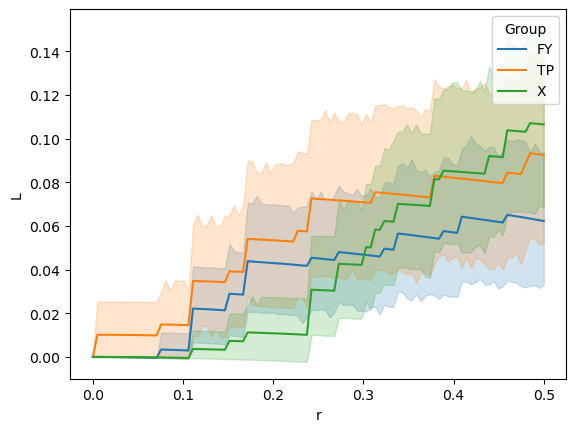

In [8]:

sns.lineplot(data=df3, x="r",y="L",hue="Group")

In [32]:
df4 = pd.concat([df3.groupby(["CID","Stack"])["L","r"].apply(lambda x: np.interp(0.25,x["r"],x["L"])),df3.groupby(["CID","Stack"])["Group"].first()],axis=1).rename(columns= {0:'%'}).dropna()
df4.head()

C:\Users\Raphael\AppData\Local\Temp\ipykernel_1392\211226237.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df4 = pd.concat([df3.groupby(["CID","Stack"])["L","r"].apply(lambda x: np.interp(0.25,x["r"],x["L"])),df3.groupby(["CID","Stack"])["Group"].first()],axis=1).rename(columns= {0:'%'}).dropna()


% Group
CID Stack                
3   6     -0.013521    FY
    7     -0.012470    FY
    8     -0.012887    FY
    9     -0.008234    FY
    10    -0.007483    FY

<AxesSubplot:xlabel='Group', ylabel='%'>

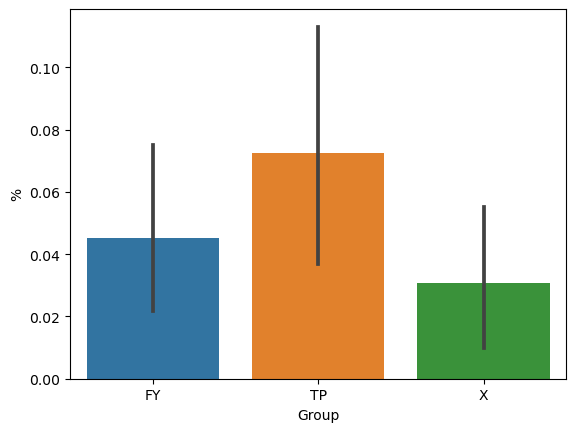

In [33]:
sns.barplot(data=df4,x = "Group",y="%")

In [34]:
import scipy.stats as stats

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df4[df4["Group"]=="X"]['%'].dropna(), df4[df4["Group"]=="TP"]['%'].dropna(), df4[df4["Group"]=="FY"]['%'].dropna())
print(fvalue, pvalue)

1.9827831013667174 0.1384647212564565


In [35]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df4['%'].dropna(), groups=df4['Group'].dropna(), alpha=0.05)
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
FY,TP,0.0272,0.3895,-0.0216,0.076,False
FY,X,-0.0145,0.7424,-0.0607,0.0317,False
TP,X,-0.0417,0.119,-0.0913,0.0079,False


In [36]:
df5 = df2[df2["X"]=="LAMP1"][df2["Y"]=="AB"]

C:\Users\Raphael\AppData\Local\Temp\ipykernel_1392\2860996729.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = df2[df2["X"]=="LAMP1"][df2["Y"]=="AB"]


In [37]:
df6 = pd.concat([df5.groupby(["CID","Stack"])["L","r"].apply(lambda x: np.interp(0.25,x["r"],x["L"])),df5.groupby(["CID","Stack"])["Group"].first()],axis=1).rename(columns= {0:'%'}).dropna()
df6.head()

C:\Users\Raphael\AppData\Local\Temp\ipykernel_1392\1682409247.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df6 = pd.concat([df5.groupby(["CID","Stack"])["L","r"].apply(lambda x: np.interp(0.25,x["r"],x["L"])),df5.groupby(["CID","Stack"])["Group"].first()],axis=1).rename(columns= {0:'%'}).dropna()


% Group
CID Stack                
3   6     -0.000267    FY
    7     -0.000273    FY
    8      0.000000    FY
    9      0.000000    FY
    10    -0.000271    FY

<AxesSubplot:xlabel='Group', ylabel='%'>

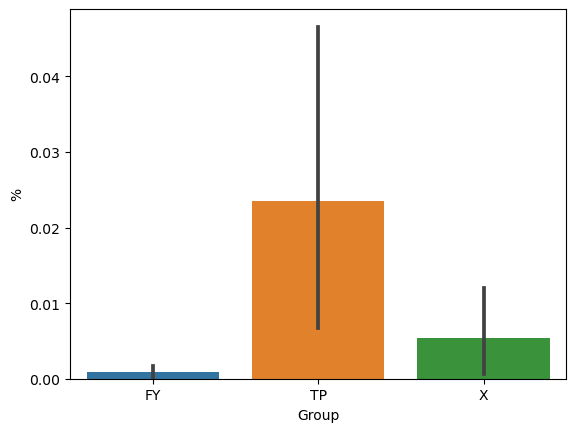

In [38]:
sns.barplot(data=df6,x = "Group",y="%")

In [39]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df6[df6["Group"]=="X"]['%'].dropna(), df6[df6["Group"]=="TP"]['%'].dropna(), df6[df6["Group"]=="FY"]['%'].dropna())
print(fvalue, pvalue)

4.719851274159982 0.009204709776578774


In [40]:
m_comp = pairwise_tukeyhsd(endog=df6['%'].dropna(), groups=df6['Group'].dropna(), alpha=0.05)
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
FY,TP,0.0226,0.0089,0.0047,0.0405,True
FY,X,0.0045,0.8056,-0.0124,0.0215,False
TP,X,-0.0181,0.0522,-0.0362,0.0001,False


C:\Users\Raphael\anaconda3\envs\pathophysiology\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 21.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Raphael\anaconda3\envs\pathophysiology\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Raphael\anaconda3\envs\pathophysiology\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Group', ylabel='%'>

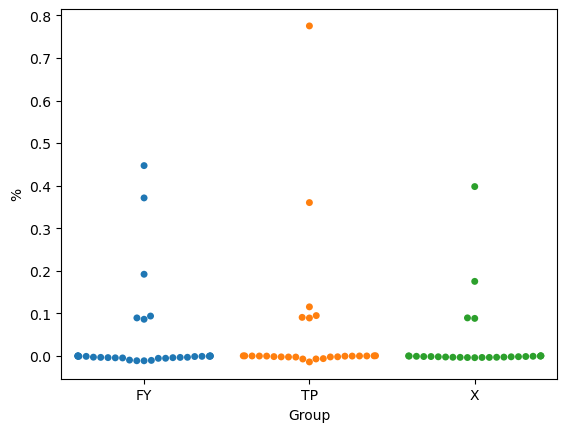

In [49]:
#df7 = pd.concat([df4.groupby(["CID"])["%"].mean(numeric_only=True),df4.groupby(["CID"])["Group"].first()],axis=1)
#df7.head()
#sns.swarmplot(data=df7,x = "Group",y="%")

In [ ]:
#df2.to_excel(os.path.join(basedir,"LAMP1_Manders.xlsx"),index_label="CID")

In [ ]:
import seaborn as sns
sns.boxplot(data=df2,x = "Group1",y="Manders_GFP_M1")

In [ ]:
sns.boxplot(data=df2,x = "Group1",y="Manders_GFP_M2")

In [ ]:
sns.boxplot(data=df2,x = "Group1",y="Manders_AB_M1",hue="Replicate")

In [ ]:
sns.boxplot(data=df2,x = "Group1",y="Manders_AB_M2")

In [ ]:
sns.barplot(data=df2,x = "Group1",y="Manders_AB_M1",hue="Replicate")

In [ ]:
sns.boxplot(data=df2,x = "Group1",y="Pearson_GFP")

In [ ]:
sns.boxplot(data=df2,x = "Group1",y="Pearson_AB")

In [ ]:
df2.groupby(["Group1"])['Manders_AB_M1'].mean()

In [ ]:
import scipy.stats as stats
df2 =df2.dropna()
df3 = df2[df2["Replicate"]==2]
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df3[df3["Group1"]=="X"]['Manders_AB_M1'].dropna(), df3[df3["Group1"]=="TP"]['Manders_AB_M1'].dropna(), df3[df3["Group1"]=="FY"]['Manders_AB_M1'].dropna())
print(fvalue, pvalue)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df3['Manders_AB_M1'].dropna(), groups=df3['Group1'].dropna(), alpha=0.05)
m_comp.summary()

In [ ]:
fvalue, pvalue = stats.f_oneway(df3[df3["Group1"]=="X"]['Manders_AB_M2'].dropna(), df3[df3["Group1"]=="TP"]['Manders_AB_M2'].dropna(), df3[df3["Group1"]=="FY"]['Manders_AB_M2'].dropna())
print(fvalue, pvalue)
m_comp = pairwise_tukeyhsd(endog=df3['Manders_AB_M2'].dropna(), groups=df3['Group1'].dropna(), alpha=0.05)
m_comp.summary()

C:\Users\Raphael\AppData\Local\Temp\ipykernel_1392\2248934083.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['%'] = gdf['%']*100
C:\Users\Raphael\AppData\Local\Temp\ipykernel_1392\2248934083.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['%'] = gdf['%']*100
C:\Users\Raphael\AppData\Local\Temp\ipykernel_1392\2248934083.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

0.5
1.0
0.5
1.0


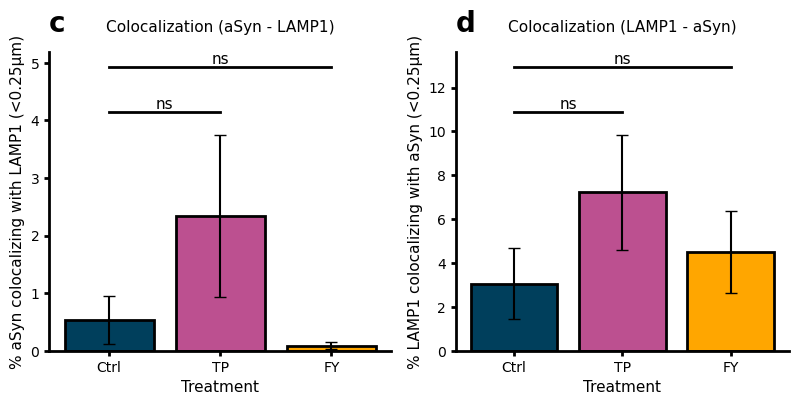

In [43]:
import pathophys as pp

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def drawsigbars(ax, ctrl, treatment, maxv, y_range, diff,pv):
    import matplotlib.pyplot as plt
    import pathophys as pp
    ctrls = ctrl
    treatments = treatment
    if (type(ctrl) is dict) == True:
        ctrls = list(ctrl.keys())[0]
        ctrl = ctrl[ctrls]
        treatments = list(treatment.keys())[0]
        treatment = treatment[treatments]
        print(ctrl)
    ax.plot(
        [ctrl, ctrl, treatment, treatment],
        [maxv, maxv, maxv, maxv], lw=2, c='k'
    )
    p = pp.convert_pvalue_to_asterisks(pv)
    ax.text((ctrl+diff), maxv, p, ha='center', va='bottom', fontsize=11)

    
pv1 = {
    "Ctrl":{
        "TP":0.0522,
        "FY":0.8056 	
    }
}
pv2 = {
    "Ctrl":{
        "TP":0.119 	,
        "FY":0.7424
    }
}
sigp = [["Ctrl","TP"],["Ctrl","FY"]]
params = pp.loadparams()
#sns.set_palette(sns.color_palette(params["Colors"]))
bs = params["BarSize"]
ls = params["LS"]
fig = plt.figure(constrained_layout=True, figsize=(20*pp.cm,10*pp.cm))
subfigs = fig.subfigures(1,2)

axUp = subfigs[0].subplots(1, 1, sharey=True)
X2 = []
X3 = []
Y2 = []
maxvs = []
i = 0
for g in ['X','TP', 'FY']:
    gdf = df6[df6["Group"]==g]
    x = g
    if g == "X":
        x = "Ctrl"
    X2.append(x)
    gdf['%'] = gdf['%']*100
    y = gdf['%'].mean()
    std = gdf['%'].std()
    err = 1.96*(std)/np.sqrt(gdf.size)
    maxvs.append(y+err)
    axUp.bar(x, y, 0.8, yerr=err, capsize=4, linewidth=ls, edgecolor="black",color=params["Colors"][i])
    i=i+1
    #CI1.append(1.96*(df["Mean"][df["Group"]==g].std())/math.sqrt(len(df[df["Group"]==g])))
for axis in ['top','bottom','left','right']:
    axUp.spines[axis].set_linewidth(ls)
    if axis in ['top','right']:
        axUp.spines[axis].set_visible(False)
axUp.tick_params(width=ls)
maxv2 = np.max(np.array(maxvs))

bottom2, top2 = axUp.get_ylim()
y_range = top2 - bottom2
hightind =  y_range*0.1
treatmenti = 0
#args = [df["Mean"][df["Group"]==g].values for g in df["Group"].unique()]
#m_comp = tukey_hsd(*args)
for pairs in sigp:
    c1 = pairs[0]
    ctrli = X2.index(c1)
    c2 = pairs[1]
    treatmenti = X2.index(c2)
    c1dic = {c1:ctrli+1}
    c2dic = {c2:treatmenti+1}
    diff = ((treatmenti-ctrli)/2)
    print(diff)
    p = pv1[c1][c2]
    drawsigbars(axUp, ctrli, treatmenti, maxv2+hightind, y_range, diff,p)
    hightind = hightind + y_range*0.2
#expected = ((1.2)**2)/2-((0.2)**2)/2
#axLo.axhline(y=expected, color='r', linestyle='--')
axUp.set_title("Colocalization (aSyn - LAMP1)", fontsize=11)
axUp.set_title("c", loc="left", fontsize=20, fontweight="bold", pad=15)
axUp.set_xlabel("Treatment", fontsize=11)
axUp.set_ylabel("% aSyn colocalizing with LAMP1 (<0.25µm)", fontsize=11)

axLo = subfigs[1].subplots(1, 1, sharey=True)
X2 = []
X3 = []
Y2 = []
maxvs = []
i = 0
for g in ['X','TP', 'FY']:
    gdf = df4[df4["Group"]==g]
    x = g
    if g == "X":
        x = "Ctrl"
    X2.append(x)
    gdf['%'] = gdf['%']*100
    y = gdf['%'].mean()
    std = gdf['%'].std()
    err = 1.96*(std)/np.sqrt(gdf.size)
    maxvs.append(y+err)
    axLo.bar(x, y, 0.8, yerr=err, capsize=4, linewidth=ls, edgecolor="black",color=params["Colors"][i])
    i=i+1
    #CI1.append(1.96*(df["Mean"][df["Group"]==g].std())/math.sqrt(len(df[df["Group"]==g])))
for axis in ['top','bottom','left','right']:
    axLo.spines[axis].set_linewidth(ls)
    if axis in ['top','right']:
        axLo.spines[axis].set_visible(False)
axLo.tick_params(width=ls)
maxv2 = np.max(np.array(maxvs))

bottom2, top2 = axLo.get_ylim()
y_range = top2 - bottom2
hightind =  y_range*0.1
treatmenti = 0
#args = [df["Mean"][df["Group"]==g].values for g in df["Group"].unique()]
#m_comp = tukey_hsd(*args)
for pairs in sigp:
    c1 = pairs[0]
    ctrli = X2.index(c1)
    c2 = pairs[1]
    treatmenti = X2.index(c2)
    c1dic = {c1:ctrli+1}
    c2dic = {c2:treatmenti+1}
    diff = ((treatmenti-ctrli)/2)
    print(diff)
    p = pv2[c1][c2]
    drawsigbars(axLo, ctrli, treatmenti, maxv2+hightind, y_range, diff,p)
    hightind = hightind + y_range*0.2
#expected = ((1.2)**2)/2-((0.2)**2)/2
#axLo.axhline(y=expected, color='r', linestyle='--')
axLo.set_title("Colocalization (LAMP1 - aSyn)", fontsize=11)
axLo.set_title("d", loc="left", fontsize=20, fontweight="bold", pad=15)
axLo.set_xlabel("Treatment", fontsize=11)
axLo.set_ylabel("% LAMP1 colocalizing with aSyn (<0.25µm)", fontsize=11)


plt.show()

In [ ]:
gfd = df3.groupby("CID").max()

In [ ]:
sns.violinplot(data=gfd,x = "Group1",y="Manders_adapted_AB")

In [ ]:
fvalue, pvalue = stats.f_oneway(gfd[gfd["Group1"]=="X"]['Manders_adapted_AB'], gfd[gfd["Group1"]=="TP"]['Manders_adapted_AB'], gfd[gfd["Group1"]=="FY"]['Manders_adapted_AB'])
print(fvalue, pvalue)

In [ ]:
m_comp = pairwise_tukeyhsd(endog=gfd['Manders_adapted_AB'].dropna(), groups=gfd['Group1'], alpha=0.05)
m_comp.summary()

In [ ]:
df["D05"] = df["Ct"]-df["p05"]
df["D01"] = df["Ct"]-df["p01"]
df["D001"] = df["Ct"]-df["p001"]

In [ ]:
df["g05"] = 0
df.loc[df["D05"]>0,"g05"] = 1
df["g01"] = 0
df.loc[df["D01"]>0,"g01"] = 1
df["g001"] = 0
df.loc[df["D001"]>0,"g001"] = 1

In [ ]:
bdf = df[df["X"]=="LAMP1"]
bdf = bdf[bdf["Y"]=="aSyn_GFP"]
bdf.head()

In [ ]:
bdf[bdf["D001"]>0][bdf["t"]==2].groupby("Group")["D05"].count()/bdf[bdf["t"]==0.5].groupby("Group")["D05"].count()

In [ ]:
from scipy.stats import chi2_contingency
XGFP = bdf[bdf["Group"]=="X"][bdf["t"]==0.5].groupby("g001")["D001"].count().values
TPGFP = bdf[bdf["Group"]=="TP"][bdf["t"]==0.5].groupby("g001")["D001"].count().values
FYGFP = bdf[bdf["Group"]=="FY"][bdf["t"]==0.5].groupby("g001")["D001"].count().values
print(XGFP)
print(TPGFP)
print(FYGFP)
res = chi2_contingency([XGFP,TPGFP])
print(res)
res = chi2_contingency([XGFP,FYGFP])
print(res)

In [ ]:
import seaborn as sns
sns.relplot(data=bdf[bdf["g001"]==1], x="t", y="D001", kind="line", hue="Group")
plt.show()

In [ ]:
sns.boxplot(data=bdf[bdf["g001"]==1][bdf["t"]==1], x="Group", y="D001")
plt.show()

In [ ]:
sns.boxplot(data=bdf, x="Group", y="Xc")
plt.show()

In [ ]:
sns.boxplot(data=bdf[bdf["t"]==0.3], x="Group", y="Yc")
plt.show()

In [ ]:
bdf.groupby("Group")["Xc"].median()

In [ ]:
bdf.groupby("Group")["Yc"].median()

In [ ]:
bdf001 = bdf[bdf["D001"]>0][bdf["Group"]=="TP"] 
sns.histplot(data=bdf001, x="t",binwidth=0.2)
plt.show()

In [ ]:
abdf = df[df["X"]=="LAMP1"]
abdf = abdf[abdf["Y"]=="aSyn_AB"]
abdf.head()

In [ ]:
abdf[abdf["D001"]>0][abdf["t"]==1].groupby("Group")["D05"].count()/abdf[abdf["t"]==0.5].groupby("Group")["D05"].count()

In [ ]:
sns.relplot(data=abdf, x="t", y="D001", kind="line", hue="Group")
plt.show()